<div align="right" style="text-align: right;"><i>Peter Norvig<br>Jotto: April 2020<br>Wordle: Jan 2022</i></div>

# Jotto and Wordle: Word Guessing Games

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a word game in which a **guesser** tries to guess a secret **target** word, which is chosen from a **word list** of allowable words, in as few guesses as possible. Each guess must be one of the allowable words, and the **reply** to each guess is the number of letters in common between the guess word and the target word, regardless of the positions of the letters.   

Here is an example Jotto game, where I show the guesses, the replies, the number of remaining targets that are **consistent** with all the replies seen so far, and finally the letters that matched (the matches are an aid to you, the reader; they are not known to the guesser). In this game, the guesser gets to the target word, "wonky", in 7 guesses. 

    Guess 1: "stoma" Reply: 1; Consistent targets: 1118    (Matched: "o")
    Guess 2: "bairn" Reply: 1; Consistent targets: 441     (Matched: "n")
    Guess 3: "swipe" Reply: 1; Consistent targets: 197     (Matched: "w")
    Guess 4: "lurks" Reply: 1; Consistent targets: 87      (Matched: "k")
    Guess 5: "rowdy" Reply: 3; Consistent targets: 14      (Matched: "owy")
    Guess 6: "roved" Reply: 1; Consistent targets: 2       (Matched: "o")
    Guess 7: "wonky" Reply: 5; Consistent targets: 1       (Matched: "wonky")


There are several variants of the game; here are five key questions and my answers:

- Q: How many letters can each word be? <br>A: **Only five-letter words are allowed**.
- Q: Does a guess have to be a word in the word list? <br>A: **Yes.**
- Q: What is the reply for a word that has the same letter twice, like the "s" in "stars"? <br>A: **Only words with no repeated letters are allowed in the word list**.
- Q: What if the reply is "5", but the guess is not the target?<br>A: **No two words in the word list are allowed to have the same set of five letters**.<br>(For example, only one of the anagrams apers/pares/parse/pears/reaps/spare/spear is allowed.)
- Q: Who chooses the target word? <br>A: **Random chance**. Jotto is sometimes a two-person game where the chooser is an adversary, but not here.

# Jotto Preliminaries

First off, some Python basics: Import some modules and define the basic types `Word`, `Score`, and `Reply`:

In [1]:
from typing      import List, Tuple, Dict, Union, Counter, Callable, Iterable
from dataclasses import dataclass
from statistics  import mean, median, stdev
from collections import defaultdict
from math        import log2
import random
import matplotlib.pyplot as plt

Word  = str # A word is a lower-case string of five different letters
Score = int # A score is the number of guesses it took to get the target word
Reply = int # A reply is the number of letters in common between guess and target words

We can make a Jotto word list by:
- Starting with a list of words.
- Discarding the ones that don't have 5 distinct letters.
- Putting the rest into a dict of anagrams keyed by the set of letters.
- Keeping only one word for each anagram.

In [2]:
def allowable(words) -> List[Word]:
    """Build a list of allowable Jotto words from an iterable of words."""
    anagrams = {frozenset(w): w for w in words if len(w) == 5 == len(set(w))}
    return list(anagrams.values())

The [Stanford GraphBase project](https://www-cs-faculty.stanford.edu/~knuth/sgb.html) has a nice list of five-letter words, [sgb-words.txt](sgb-words.txt):

In [3]:
! [ -e sgb-words.txt ] || curl -O https://norvig.com/ngrams/sgb-words.txt
    
sgb_words = open('sgb-words.txt').read().split()
wordlist  = allowable(sgb_words)

len(sgb_words), len(wordlist)

(5756, 2845)

We see there are 2,845 allowable Jotto words out of the 5,756 words in [sgb-words.txt](sgb-words.txt).

# Playing Jotto

The function `play` will play a game of Jotto and return the score (the number of guesses). The  arguments are:
- `guesser`: a `callable` (e.g., a function) that should return the guess to make. The guesser is passed two arguments: 
  - The reply to the previous guess.
  - A list of the words that are consistent with all the guesses made so far. 
<br>(If the guesser wants to keep track of all the guesses made so far, or all the words in the word list, it is welcome to do so.)
- `target`: The target word. If none is given, the target word is chosen at random from the wordlist.
- `wordlist`: The list of allowable words.
- `verbose`: Unless false, print a message for each guess.

Two corner cases: 
1. If the guesser improperly guesses a non-word, the reply is `None`. 
2. To prevent a poor guesser from creating an infinite loop, the worst score you can get is the number of words in the wordlist.

In [4]:
Guesser = Callable[[Reply, List[Word]], Word]

def play(guesser: Guesser, target=None, wordlist=wordlist, verbose=True) -> Score:
    """How many guesses does it take for `guesser` to guess the Jotto target word,
    which is selected by `chooser` from the words in `wordlist`?"""
    target  = target or random.choice(wordlist) # Choose a random target if none was given
    targets = wordlist      # The targets that are consistent with all replies
    reply   = None          # For the first guess, there is no previous reply
    N       = len(wordlist) # After N guesses stop the game and record a score of N
    for i in range(1, N + 1):
        guess = guesser(reply, targets)
        reply = reply_for(guess, target) if guess in wordlist else None
        targets = [t for t in targets if reply_for(guess, t) == reply]
        if verbose: 
            print(f'Guess {i}: "{guess}" Reply: {reply}; Consistent targets: {len(targets)}')
        if guess == target or i == N:  
            return i
                         
def reply_for(guess, target) -> Reply: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

To play a game, we will need a guesser. Here are two simple ones:
- `human_guesser` asks a human for `input`.
- `random_guesser` guesses one of the remaining consistent  targets, picked at random. 


In [5]:
def human_guesser(reply, targets) -> Word: return input(f'Reply was {reply}. Your guess? ')

def random_guesser(reply, targets) -> Word: return random.choice(targets)

# Sample Jotto Games

Here is the `random_guesser` in action:

In [6]:
play(random_guesser)

Guess 1: "bolas" Reply: 1; Consistent targets: 1119
Guess 2: "dregs" Reply: 2; Consistent targets: 443
Guess 3: "exits" Reply: 0; Consistent targets: 34
Guess 4: "prong" Reply: 1; Consistent targets: 6
Guess 5: "darky" Reply: 5; Consistent targets: 1


5

In [7]:
play(random_guesser)

Guess 1: "shelf" Reply: 2; Consistent targets: 981
Guess 2: "lamed" Reply: 3; Consistent targets: 152
Guess 3: "velar" Reply: 3; Consistent targets: 44
Guess 4: "equal" Reply: 2; Consistent targets: 17
Guess 5: "veldt" Reply: 4; Consistent targets: 2
Guess 6: "loved" Reply: 5; Consistent targets: 1


6

In [8]:
play(random_guesser, target='world')

Guess 1: "agues" Reply: 0; Consistent targets: 192
Guess 2: "fitly" Reply: 1; Consistent targets: 68
Guess 3: "crimp" Reply: 1; Consistent targets: 20
Guess 4: "horny" Reply: 2; Consistent targets: 6
Guess 5: "plonk" Reply: 2; Consistent targets: 1
Guess 6: "world" Reply: 5; Consistent targets: 1


6

# Evaluating Guessers

To properly evaluate a guesser, a sample of 3 games is not enough. We will have to play at least a few hundred  games to get a statistically reliable result. The function `evaluate` takes a list of scores from playing multiple games and reports the following statistics:
- The median, mean, standard deviation, and worst case number of guesses, and total number of scores.
- The cumulative percentages guessed correctly (e.g., `"≤5:11%"` means 11% of the targets took 5 or fewer guesses).
- A histogram of scores.

In [9]:
def report(scores: Iterable[Score]) -> None:
    """Report statistics and a histogram for these scores."""
    scores  = list(scores)
    ctr     = Counter(scores)
    bins    = range(min(ctr), max(ctr) + 2)
    scale   = 100 / len(scores)
    weights = [scale * ctr[score] for score in ctr]
    plt.hist(list(ctr), weights=weights, align='left', rwidth=0.9, bins=bins)
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses'); plt.ylabel('% of scores')
    print(f'median: {median(scores):.0f} guesses, mean: {mean(scores):.2f}',
          f'± {stdev(scores):.2f}, worst: {max(scores)}, scores: {len(scores):,d}')
    def pct(g): 
        """What percent of games requires no mare than g guesses?"""
        percent = scale * sum(ctr[i] for i in range(1, g + 1))
        return round(percent, (1 if 99 < percent < 100 else None))
    print('cumulative:', ', '.join(f'≤{g}:{pct(g)}%' for g in range(3, 11)))

I'll evaluate `random_guesser` on every word in the word list:

median: 7 guesses, mean: 7.36 ± 1.66, worst: 15, scores: 2,845
cumulative: ≤3:1%, ≤4:3%, ≤5:10%, ≤6:29%, ≤7:56%, ≤8:79%, ≤9:92%, ≤10:96%


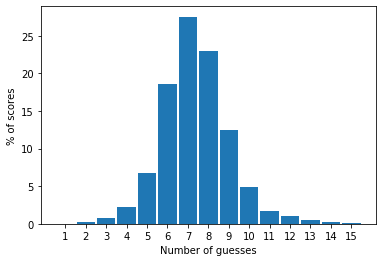

In [10]:
report(play(random_guesser, target, verbose=False) for target in wordlist)

The random consistent guesser strategy might have seemed hopelessly naive, but it is actually a pretty decent strategy. The median is 7 guesses and about 80% of the time it will take 8 guesses or fewer. Can a better strategy improve on that?

#  Guessers that Partition Target Words

A key idea in guessing is to reduce the number of consistent targets. When there is a single consistent target left, the game is over. We can think of a guess as **partitioning** the consistent targets into different **branches** of a tree, each branch corresponding to a different reply:

In [11]:
def partition(guess, targets) ->  Dict[Reply, List[str]]:
    """A guess partition targets by the possible replies to guess: {reply: [word, ...]}."""
    branches = defaultdict(list)
    for target in targets:
        branches[reply_for(guess, target)].append(target)
    return branches

Here are two different partitions of just the first 22 words in `wordlist`; one by the guess word `'girth'` and one by `'ethos'`:

In [12]:
words22 = wordlist[:22]

partition('girth', words22)

defaultdict(list,
            {4: ['their', 'might'],
             1: ['about', 'sword', 'resay', 'nuder', 'house'],
             0: ['would', 'cloud', 'place', 'sound', 'fondu'],
             3: ['throe', 'write', 'rifts', 'think', 'grate'],
             2: ['water', 'after', 'ethos', 'while'],
             5: ['girth']})

In [13]:
partition('ethos', words22)

defaultdict(list,
            {3: ['their'],
             2: ['about',
              'sword',
              'write',
              'rifts',
              'water',
              'after',
              'girth',
              'think',
              'resay',
              'sound',
              'grate',
              'might',
              'while'],
             1: ['would', 'cloud', 'place', 'fondu', 'nuder'],
             4: ['throe', 'house'],
             5: ['ethos']})

We see that after guesssing `'girth'`, no matter what the reply is, we will be left with no more than 5 targets. However, if we guessed `'ethos'` then a majority of the time the reply would be 2, and there would be 13 possible targets remaining. That  suggests that `'girth'` is a better guess and that a good strategy is: **guess a word that partitions the possible targets into branches with small numbers of words.**

Since we only need to know the *size* of each branch, not the list of words therein, we can use `partition_counts`:

In [14]:
def partition_counts(guess, targets) -> List[int]: 
    "The sizes of the branches of a partition of targets by guess."
    counter = Counter(reply_for(guess, target) for target in targets)
    return list(counter.values())

In [15]:
partition_counts('girth', words22)

[2, 5, 5, 5, 4, 1]

In [16]:
partition_counts('ethos', words22)

[1, 13, 5, 2, 1]

# Finding Good Partitions

What exactly is the best metric for deciding which partition is best? Ideally, we want the partition that minimizes the average number of additional guesses it will take to finish the game, but since we don't know that, we can instead minimize one of the following proxy metrics to rank partitions, based on the sizes of the branches:

- **Maximum**: choose the partition that minimizes the size of the largest branch.


- **Expectation**: In probability theory the expectation or **expected value** is the weighted average of a random variable. Here it means the sum, over all branches, of the size of the branch multiplied by the probability of ending up in the branch; that's what we want to minimize. We are assuming that every target is equally likely, so the probability of a branch is proportional to the number of targets in it.

- **Negative Entropy**: Entropy is an information-theoretic measure that is similar to expectation, except that it weights each branch size by its base 2 logarithm (whereas expectation weights it by its actual size). We want to maximkize entropy, or minimize *negative* entropy.

The maximum is just the builtin `max` function; here are the other two metrics:

In [17]:
def expectation(counts: List[int]) -> float:
    "The expected value of the counts."
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * x for x in counts)

def neg_entropy(counts: List[int]) -> float: 
    """The negation of the entropy of the counts."""
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * log2(P(x)) for x in counts)

# Best and Worst First Guesses

Here's a function to print a table of the best and worst words to partition the word list–that is, the best and worst first guesses in a game–according to each of the three metrics:

In [18]:
def partition_scores(n, metrics=(max, expectation, neg_entropy), wordlist=wordlist): 
    """The top and bottom `n` words to guess, according to each partition metric."""
    rankings = {metric: sorted((metric(partition_counts(g, wordlist)), g) for g in wordlist)
                for metric in metrics}
    def fmt(score): 
        return f'{round(score):5d}' if score >= 100 or isinstance(score, int) else f'{score:5.2f}'
    bar = ' + '.join(['-' * 11] * len(metrics))
    print(' | '.join(f'{metric.__name__:11}' for metric in metrics))
    print(bar)
    for i in [*range(n), *range(-n, 0)]:
        fmts = [f'{word} {fmt(score)}' for metric in metrics 
                for score, word in [rankings[metric][i]]]
        if i == -n: print(bar)
        print(' | '.join(fmts))

First I'll try it with the 22-word list:

In [19]:
partition_scores(11, wordlist=words22)

max         | expectation | neg_entropy
----------- + ----------- + -----------
girth     5 | girth  4.36 | girth -2.42
after     6 | grate  4.45 | grate -2.41
grate     6 | after  4.55 | after -2.39
write     6 | write  4.64 | write -2.38
might     8 | their  4.91 | their -2.36
place     8 | water  4.91 | water -2.36
rifts     8 | would  5.27 | would -2.26
their     8 | might  5.55 | might -2.21
think     8 | think  5.64 | fondu -2.20
throe     8 | rifts  5.73 | sound -2.18
water     8 | fondu  5.73 | cloud -2.11
----------- + ----------- + -----------
would     8 | sound  5.82 | think -2.10
fondu     9 | throe  5.91 | rifts -2.08
house     9 | resay  6.00 | resay -2.06
resay     9 | cloud  6.36 | throe -2.04
sound     9 | while  6.55 | while -1.96
while     9 | sword  6.82 | sword -1.94
about    10 | place  6.82 | house -1.77
cloud    10 | house  7.64 | place -1.77
sword    10 | nuder  8.00 | nuder -1.75
nuder    11 | ethos  9.09 | ethos -1.65
ethos    13 | about  9.18 | about -1.44


The three metrics are similar; "girth" is good and "ethos" is bad on all three metrics.

Now with the full wordlist (this will take about 12 seconds to run):

In [20]:
partition_scores(16)

max         | expectation | neg_entropy
----------- + ----------- + -----------
wader  1012 | raved   813 | debar -1.95
cadre  1026 | debar   818 | alder -1.95
armed  1028 | roved   827 | raved -1.94
diner  1029 | orbed   827 | dater -1.94
coder  1030 | wader   827 | cadre -1.94
padre  1035 | armed   827 | armed -1.94
raved  1038 | fader   828 | garde -1.94
rayed  1038 | dater   829 | wader -1.94
delta  1039 | alder   830 | lased -1.93
drone  1041 | cadre   830 | padre -1.93
eland  1043 | garde   830 | fader -1.93
garde  1043 | padre   832 | dears -1.93
heard  1044 | deign   832 | drone -1.93
tired  1044 | gored   834 | diner -1.93
debar  1046 | laved   834 | rayed -1.93
fader  1048 | rayed   837 | tired -1.93
----------- + ----------- + -----------
vacuo  1465 | jumpy  1067 | gauzy -1.61
miaow  1474 | gauze  1067 | quake -1.61
pique  1480 | juicy  1070 | humpf -1.61
okapi  1485 | quail  1073 | coqui -1.61
imago  1491 | imago  1081 | whump -1.60
haiku  1493 | miaow  1084 | diazo -1.60


The top guesses  favor the letters "a", "d", "e", and "r". 

The word "ouija" is a uniquely terrible guess; mostly what it does is confirm that a majority of the words have exactly one of the vowels "aiou".

#  Guess Trees: Caching Best Guesses

Going through every word in the wordlist to decide which one makes the best partition takes some time. I would prefer to do that computation just once and cache it, rather than have to repeat the computation in every new game. I will cache the best guesses in a structure called a **guess tree**: a tree that has branches for every possible path the game might take, with the best guess for each situation already computed. A guess tree is either:
- An **interior node**, which has a guess and a dict of branches, `Node(guess, {reply: subtree, ...})`, where  each subtree covers all the target words that are consistent with the corresponding reply.
- A **leaf word**,  indicating the sole remaining consistent target word. Every word in the word list should appear as a leaf in exactly one place in a guess tree.

In [21]:
@dataclass 
class Node:
    """A node in a tree. It stores the best guess, and a branch for every possible reply."""
    guess: Word
    branches: Dict[Reply, 'Tree']

Tree = Union[Node, Word] # A Tree is either  an interior Node or a leaf Word

The function `minimizing_tree(metric, targets)` builds a guess tree that covers all the targets and that, at every node, guesses a word that  minimizes the `metric` applied to the `partition_counts` of the guess.

In [22]:
def minimizing_tree(metric, targets) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: minimizing_tree(metric, branches[reply]) 
                            for reply in branches})

Here is a tree that covers a small list of five words:

In [23]:
words5 = ['purge', 'bites', 'sulky', 'patsy', 'hayed']

tree5  = minimizing_tree(max, words5)

assert tree5 == Node(guess='bites', 
                     branches={1: Node(guess='purge', 
                                       branches={1: Node(guess='sulky', 
                                                         branches={1: 'hayed', 5: 'sulky'}), 
                                                 5: 'purge'}), 
                               2: 'patsy', 
                               5: 'bites'})

The tree says that the first guess is `'bites'`, and if the reply is `1` there is a complex subtree to consider (starting with the guess `'purge'`), but if the reply is `2` the target can only be `'patsy'` and of course if the reply is `5` then `'bites'` was the target and the game is over.

# Turning a Tree into a Guesser

A tree is not a guesser, but we can easily make a guesser from a tree. A `TreeGuesser` works as follows:
- When *initialized*, it takes a tree as input, and stores the tree under the `.root` attribute.
- When *called* for the first turn in a game (when the reply is `None`), it resets `.tree`  to `.root`.
- When *called* on subsequent turns within a game, it updates `.tree` to be the branch corresponding to the reply.
- It then returns the guess for that branch: either the `.guess` attribute  or the leaf word. 

In [24]:
class TreeGuesser:
    """Given a guess tree, use it to create a callable Guesser that can play Jotto."""
    def __init__(self, tree): self.root = tree
        
    def __call__(self, reply, targets) -> str:
        """If reply is None, start a new game; otherwise follow the branch for the reply.
        Then return the current leaf or interior node guess."""
        self.tree = self.root if reply is None else self.tree.branches[reply]
        return self.tree.guess if isinstance(self.tree, Node) else self.tree

# Sample Jotto Games with Minimizing Guesser

Here we build a tree that minimizes the maximum branch size (over the full wordlist), and use it to play a few games:

In [25]:
tree = minimizing_tree(max, wordlist)
guesser = TreeGuesser(tree)

In [26]:
play(guesser)

Guess 1: "wader" Reply: 0; Consistent targets: 466
Guess 2: "tings" Reply: 1; Consistent targets: 142
Guess 3: "hypos" Reply: 3; Consistent targets: 32
Guess 4: "clops" Reply: 4; Consistent targets: 6
Guess 5: "coups" Reply: 4; Consistent targets: 2
Guess 6: "comps" Reply: 4; Consistent targets: 1
Guess 7: "pocks" Reply: 5; Consistent targets: 1


7

In [27]:
play(guesser)

Guess 1: "wader" Reply: 3; Consistent targets: 319
Guess 2: "sword" Reply: 2; Consistent targets: 112
Guess 3: "weans" Reply: 1; Consistent targets: 37
Guess 4: "dicer" Reply: 2; Consistent targets: 7
Guess 5: "hydra" Reply: 3; Consistent targets: 3
Guess 6: "guard" Reply: 4; Consistent targets: 1
Guess 7: "fraud" Reply: 5; Consistent targets: 1


7

In [28]:
play(guesser)

Guess 1: "wader" Reply: 1; Consistent targets: 1012
Guess 2: "actin" Reply: 2; Consistent targets: 355
Guess 3: "flats" Reply: 4; Consistent targets: 15
Guess 4: "stalk" Reply: 3; Consistent targets: 7
Guess 5: "fault" Reply: 4; Consistent targets: 3
Guess 6: "aloft" Reply: 3; Consistent targets: 1
Guess 7: "tufas" Reply: 5; Consistent targets: 1


7

# Making Inconsistent Guesses

So far,  we have always guessed one of the consistent targets. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it ***is*** a good strategy to guess such a word.

I will redefine `minimizing_tree` so that it is passed both the list of remaining consistent target words and the complete word list. It also takes a flag, `inconsistent`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only consistent targets are considered, as before. (Note: when there are 3 or fewer target words left there is no use considering inconsistent guesses, since they cannot improve the average score over a consistent guess.)

In [29]:
def minimizing_tree(metric, targets, wordlist=wordlist, inconsistent=False) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guesses  = wordlist if (inconsistent and len(targets) > 3) else targets
        guess    = min(guesses, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: minimizing_tree(metric, branches[reply], wordlist, inconsistent) 
                            for reply in sorted(branches)})

Here we see that by default, `minimizing_tree` behaves just as it did before:

In [30]:
assert minimizing_tree(max, words5) == (
    Node(guess='bites', 
         branches={1: Node(guess='purge', 
                           branches={1: Node(guess='sulky', 
                                             branches={1: 'hayed', 5: 'sulky'}), 
                                     5: 'purge'}), 
                                     2: 'patsy', 5: 'bites'}))

But with `inconsistent=True`, we get a better tree:

In [31]:
tree5i = minimizing_tree(max, words5, inconsistent=True)
tree5i

Node(guess='dashy', branches={0: 'purge', 1: 'bites', 2: 'sulky', 3: 'patsy', 4: 'hayed'})

The first guess by `tree5i` is an inconsistent word (not one of the words in `words5`). There is no chance that this is the target, but it sets us up so that we will always be able to guess correctly on the second guess. So the minimum, mean, median, and maximum number of guesses is 2. 

In contrast, `tree5` makes only consistent guesses and has a mean of 2.4 guesses and a maximum of 4:

In [32]:
[play(TreeGuesser(tree5), w, words5, False) # The 5 scores for tree5
 for w in words5] 

[2, 1, 3, 2, 4]

# Evaluating Guess Trees

We could evaluate a Guess Tree with repeated calls to `play`, but there is a faster way: walk the tree and keep track of how many guesses it takes to get to each leaf word. The function `tree_scores` does this. For each subtree branch in the tree there are three cases:
- If the subtree is a leaf word that is the same as the node's guess, we're done; it took one guess.
- If the subtree is a leaf word that is not the guess, it took two guesses: one for the incorrect guess and one for the leaf word.
- If the subtree is a Node, add one to each of the scores from the subtree and yield those scores.

In [33]:
def tree_scores(node: Node) -> Iterable[Score]:
    """All the scores for playing all the target words in the tree under `node`."""
    for subtree in node.branches.values():
        if isinstance(subtree, Word):
            yield 1 if subtree == node.guess else 2
        else:
            yield from (score + 1 for score in tree_scores(subtree))
            
assert sorted(tree_scores(tree5)) == [1, 2, 2, 3, 4]

# Evaluating Consistent Guessers

Here are the evaluations of trees made from minimizing the three metrics, with only consistent guesses allowed:

median: 7 guesses, mean: 7.15 ± 1.81, worst: 18, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:35%, ≤7:67%, ≤8:86%, ≤9:92%, ≤10:95%
CPU times: user 6.28 s, sys: 8.54 ms, total: 6.29 s
Wall time: 6.29 s


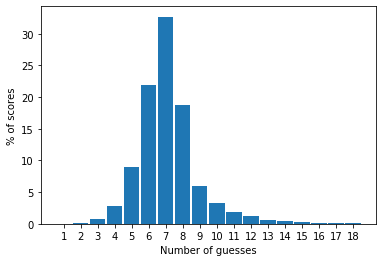

In [34]:
%time report(tree_scores(minimizing_tree(max, wordlist, inconsistent=False)))

median: 7 guesses, mean: 7.14 ± 1.82, worst: 17, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:68%, ≤8:85%, ≤9:91%, ≤10:95%
CPU times: user 6.38 s, sys: 14 ms, total: 6.4 s
Wall time: 6.4 s


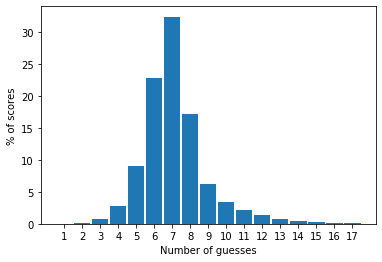

In [35]:
%time report(tree_scores(minimizing_tree(expectation, wordlist, inconsistent=False)))

median: 7 guesses, mean: 7.09 ± 1.78, worst: 19, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:69%, ≤8:86%, ≤9:92%, ≤10:96%
CPU times: user 6.37 s, sys: 8.47 ms, total: 6.38 s
Wall time: 6.38 s


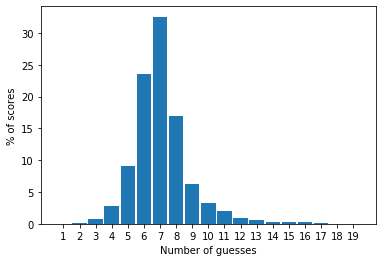

In [36]:
%time report(tree_scores(minimizing_tree(neg_entropy, wordlist, inconsistent=False)))

We might as well also get an evaluation of the random guesser on every target in the wordlist:

median: 7 guesses, mean: 7.33 ± 1.67, worst: 16, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:11%, ≤6:30%, ≤7:58%, ≤8:80%, ≤9:91%, ≤10:96%
CPU times: user 6.71 s, sys: 7.95 ms, total: 6.72 s
Wall time: 6.72 s


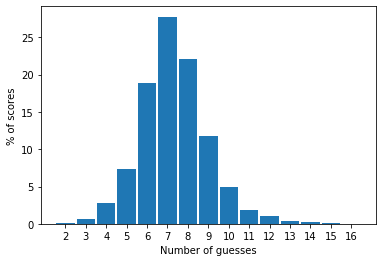

In [37]:
%time report(play(random_guesser, target, verbose=False) for target in wordlist)

# Evaluating Inconsistent Guessers

Now we'll build and evaluate trees with inconsistent guesses allowed. This will take longer; about 30 seconds per tree.

median: 7 guesses, mean: 7.05 ± 0.98, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:6%, ≤6:24%, ≤7:69%, ≤8:95%, ≤9:99.9%, ≤10:100%
CPU times: user 28.3 s, sys: 25.1 ms, total: 28.3 s
Wall time: 28.3 s


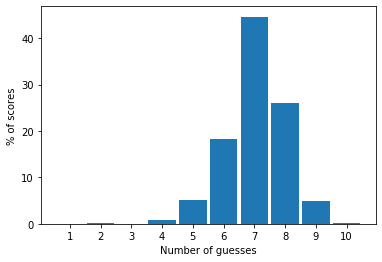

In [38]:
%time report(tree_scores(minimizing_tree(max, wordlist, inconsistent=True)))

median: 7 guesses, mean: 6.84 ± 0.95, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:7%, ≤6:32%, ≤7:78%, ≤8:97%, ≤9:100.0%, ≤10:100%
CPU times: user 28.8 s, sys: 26.2 ms, total: 28.8 s
Wall time: 28.8 s


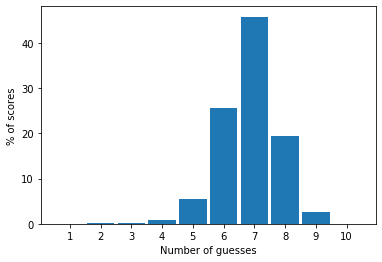

In [39]:
%time report(tree_scores(minimizing_tree(expectation, wordlist, inconsistent=True)))

median: 7 guesses, mean: 6.82 ± 1.00, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:8%, ≤6:35%, ≤7:78%, ≤8:97%, ≤9:99.6%, ≤10:100%
CPU times: user 29.6 s, sys: 20.5 ms, total: 29.6 s
Wall time: 29.6 s


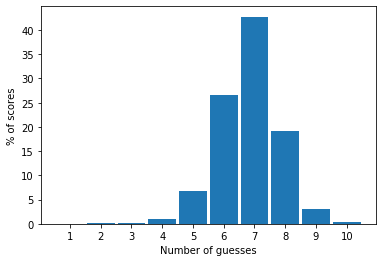

In [40]:
%time report(tree_scores(minimizing_tree(neg_entropy, wordlist, inconsistent=True)))

# Jotto Evaluation Summary

Here's a table of evaluation results for the mean and maximum number of guesses for the various approaches:

|<br><br>Algorithm|Consistent<br><u>Only</u><br>Mean (Max)|Inconsistent<br><u>Allowed</u><br>Mean (Max)|
|--|--|--|
|random guesser|7.33 (16)|  |
|minimize max|7.15 (18)|7.05 (10)|
|minimize expectation|7.14 (17)|6.84 (10)|
|minimize neg_entropy|7.09 (19)|6.82 (10)|

(There can be slight variation from run to run.)


# Wordle

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a [suddenly-popular](https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html) variant of Jotto (with some Mastermind thrown in) with these differences:
- Words with repeated letters are allowed, as are anagrams.
- The reply to a guess consists of 5 pieces ([trits](https://en.wiktionary.org/wiki/trit#English)) of information, one for each position in the guess:
  - *Green* if the guess letter is in the correct spot.
  - *Yellow* if the guess letter is in the word but in the wrong spot.
  - *Miss* if the letter is not in the word in any spot.
  
Since repeated letters and anagrams are allowed, I can use all of `sgb_words` as my list of allowable Wordle words.

There seems to be an ambiguity in the rules. Assume the guess is *etude* and the target is *poems*. I think the correct reply should be that one letter *e* is *yellow* and the other is a *miss*, although a strict reading of the rules would say they both should be *yellow*, because both instances of *e* are "in the word but in the wrong spot." I decided that in cases like this I would report the first one as yellow and the second as a miss.

In [41]:
Green, Yellow, Miss = 'GY.' # A reply is 5 characters, each one of 'GY.'

def wordle_reply_for(guess, target) -> str: 
    "The five-character reply for this guess on this target in Wordle."
    # We'll start by having each reply be either Green or Miss ...
    reply = [Green if guess[i] == target[i] else Miss for i in range(5)]
    # ... then we'll put in the replies that should be yellow
    counts = Counter(target[i] for i in range(5) if guess[i] != target[i])
    for i in range(5):
        if reply[i] == Miss and counts[guess[i]] > 0:
            counts[guess[i]] -= 1
            reply[i] = Yellow
    return ''.join(reply)

The right thing to do now would be to refactor the code to allow for the injection of a different `reply_for` function. However, I'm not going to do that; instead I'm going to "cheat" and just redefine `reply_for` to be `wordle_reply_for`. So if you want to go back in this notebook and re-run some Jotto cells, you'll have to re-run the "`def reply_for`" cell first.

In [42]:
reply_for = wordle_reply_for

Note that in Jotto, `reply_for` was symmetric; `reply_for(g, t) == reply_for(t, g)`. But that is not true for Wordle. (I had a bug somewhere in my code that showed up when playing Wordle but not Jotto, and I thought it might be because I had inadvertently reversed arguments to `reply_for` somewhere (but it turned out to be that I had left out a `wordlist=sgb_words`).) Anyway, here are some tests for `wordle_reply_for`:

In [43]:
assert reply_for('treat', 'truss') == 'GG...'  and  reply_for('truss', 'treat') == 'GG...'
assert reply_for('stars', 'traps') == '.YGYG'  and  reply_for('traps', 'stars') == 'YYG.G'
assert reply_for('palls', 'splat') == 'YYG.Y'  and  reply_for('splat', 'palls') == 'YYGY.'
assert reply_for('banal', 'apple') == '.Y..Y'  and  reply_for('apple', 'banal') == 'Y..Y.'
assert reply_for('banal', 'mania') == '.GGY.'  and  reply_for('mania', 'banal') == '.GG.Y'
assert reply_for('epees', 'geese') == 'Y.GYY'  and  reply_for('geese', 'epees') == '.YGYY'
assert reply_for('wheee', 'peeve') == '..GYG'  and  reply_for('peeve', 'wheee') == '.YG.G'

We can test the new `reply_for` on a partition of `words22`:

In [44]:
partition('write', words22)

defaultdict(list,
            {'.YYYY': ['their'],
             '...Y.': ['about'],
             'G....': ['would'],
             '.Y.YG': ['throe'],
             'YY...': ['sword'],
             '.....': ['cloud', 'sound', 'fondu'],
             'GGGGG': ['write'],
             '.YYG.': ['rifts', 'girth'],
             'GY.YY': ['water'],
             '.Y.YY': ['after'],
             '..GY.': ['think'],
             '.Y..Y': ['resay', 'nuder'],
             '....G': ['place', 'house'],
             '.G.GG': ['grate'],
             '...YY': ['ethos'],
             '..YY.': ['might'],
             'G.G.G': ['while']})

That looks good. Notice that there are many more possible replies in Wordle than the 6 possible replies in Jotto, so the target words are partitioned into smaller branches. It should take fewer guesses to solve a Wordle than a Jotto. How many possible replies are there? There are 3 responses at each of five positions, and  3<sup>5</sup> = 243, but five of those replies are impossible: you can't have four Greens and one Yellow, because if four letters of the guess are in the right place then the fifth must be either in the right place or a miss. 

# Sample Wordle Games

Let's see what some Wordle games with a random guesser looks like:

In [45]:
play(random_guesser, wordlist=sgb_words)

Guess 1: "tikes" Reply: Y..YY; Consistent targets: 62
Guess 2: "saute" Reply: G..YY; Consistent targets: 9
Guess 3: "smelt" Reply: G.GYG; Consistent targets: 1
Guess 4: "slept" Reply: GGGGG; Consistent targets: 1


4

In [46]:
play(random_guesser, wordlist=sgb_words)

Guess 1: "astir" Reply: .Y..Y; Consistent targets: 213
Guess 2: "preps" Reply: .YY.G; Consistent targets: 40
Guess 3: "serfs" Reply: .GG.G; Consistent targets: 13
Guess 4: "heros" Reply: GGGGG; Consistent targets: 1


4

In [47]:
play(random_guesser, wordlist=sgb_words)

Guess 1: "tests" Reply: .YY.G; Consistent targets: 38
Guess 2: "slues" Reply: GG.GG; Consistent targets: 1
Guess 3: "sloes" Reply: GGGGG; Consistent targets: 1


3

# Wordle Strategies

With the bigger `sgb_words` word list, computations take longer, so I'm only going to compare the random guesser with the two negative entropy minimizing  guessers. This will take 15 minutes or so:

median: 4 guesses, mean: 4.64 ± 1.31, worst: 14, scores: 5,756
cumulative: ≤3:17%, ≤4:52%, ≤5:79%, ≤6:92%, ≤7:97%, ≤8:99%, ≤9:99.7%, ≤10:99.9%
CPU times: user 3min 26s, sys: 185 ms, total: 3min 27s
Wall time: 3min 30s


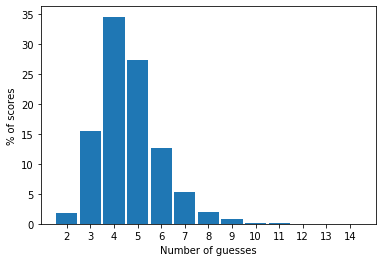

In [48]:
%time report(play(random_guesser, target, sgb_words, verbose=False) for target in sgb_words)

CPU times: user 3min 45s, sys: 147 ms, total: 3min 45s
Wall time: 3min 53s
median: 4 guesses, mean: 4.09 ± 1.20, worst: 12, scores: 5,756
cumulative: ≤3:32%, ≤4:73%, ≤5:89%, ≤6:95%, ≤7:98%, ≤8:99.4%, ≤9:99.8%, ≤10:99.9%


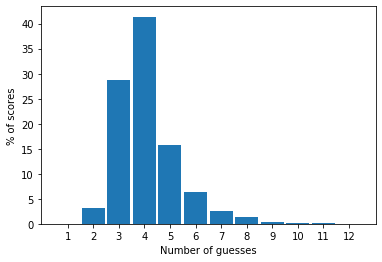

In [49]:
%time wtree = minimizing_tree(neg_entropy, sgb_words, sgb_words, inconsistent=False)
report(tree_scores(wtree))

CPU times: user 8min 54s, sys: 329 ms, total: 8min 54s
Wall time: 9min 14s
median: 4 guesses, mean: 3.82 ± 0.71, worst: 7, scores: 5,756
cumulative: ≤3:32%, ≤4:87%, ≤5:98%, ≤6:99.9%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%


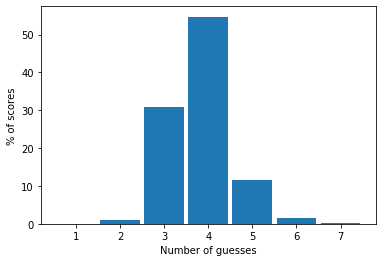

In [50]:
%time wtree = minimizing_tree(neg_entropy, sgb_words, sgb_words, inconsistent=True)
report(tree_scores(wtree))

Pretty good! The Wordle web site challenges you to solve each puzzle in six guesses; we can now do that 99.9% of the time when inconsistent guesses are allowed, a big jump from the 95% without inconsistent guesses and the 92% with random consistent guesses. 

This is all on the `sgb-words.txt` file. I poked around in the Wordle javascript, and I think I found the word list that they use. If I interpreted it correctly, my algorithm gets these results on it:

     median: 3 guesses, mean: 3.49 ± 0.60, worst: 6, scores: 2,315
     cumulative: ≤3:53%, ≤4:96%, ≤5:99.8%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
     
I won't post the word list here, because I don't have the author's permission.

# Jotto and Wordle Evaluation Summary

Here is a summary  (the first four columns on `sgb-words.txt`, the last on the Wordle word list):

|<br><br><br>Algorithm|JOTTO<br>Consistent<br><u>Only</u><br>Mean (Max)|JOTTO<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)|WORDLE<br>Consistent<br><u>Only</u><br>Mean (Max)|WORDLE<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)|WORDLE<br>Official<br><u>Wordlist</u><br>Mean (Max)|
|--|--|--|--|--|--|
|random guesser|7.33 (16)| ––––––– |4.64 (14) | ––––––– | 4.08 (8) |
|minimize max|7.15 (18)|7.05 (10)| ––––––– | ––––––– | ––––––– | ––––––– |
|minimize expectation|7.14 (17)|6.84 (10)| ––––––– | ––––––– | ––––––– | ––––––– |
|minimize neg_entropy|7.09 (19)|6.82 (10)| 4.09 (12) | 3.82 (7) | 3.49 (6) |




# Sample Wordle Games with Minimizing Guesser

Here are some sample games with the negative-entropy minimizing, inconsistent-guessing guesser:

In [51]:
play(TreeGuesser(wtree), wordlist=sgb_words)

Guess 1: "tares" Reply: ..Y..; Consistent targets: 137
Guess 2: "doing" Reply: G.Y..; Consistent targets: 1
Guess 3: "druid" Reply: GGGGG; Consistent targets: 1


3

In [52]:
play(TreeGuesser(wtree), wordlist=sgb_words)

Guess 1: "tares" Reply: ..Y..; Consistent targets: 137
Guess 2: "doing" Reply: .Y...; Consistent targets: 18
Guess 3: "clump" Reply: ...G.; Consistent targets: 1
Guess 4: "bromo" Reply: GGGGG; Consistent targets: 1


4

In [53]:
play(TreeGuesser(wtree), wordlist=sgb_words)

Guess 1: "tares" Reply: Y.Y..; Consistent targets: 32
Guess 2: "fount" Reply: .Y..G; Consistent targets: 1
Guess 3: "orbit" Reply: GGGGG; Consistent targets: 1


3

# Best and Worst First Guesses for Wordle

This will take about 10 minutes:

In [54]:
%time partition_scores(20, wordlist=sgb_words)

max         | expectation | neg_entropy
----------- + ----------- + -----------
aloes   298 | tares   133 | tares -6.21
arose   361 | rates   136 | rates -6.12
aides   383 | aloes   137 | tales -6.10
stoae   383 | tales   140 | tears -6.06
earls   393 | nares   140 | nares -6.02
reals   393 | saner   142 | tires -6.02
earns   395 | lores   144 | reals -6.00
nares   395 | reals   144 | dares -5.99
nears   395 | roles   145 | lores -5.99
saner   395 | lanes   148 | tries -5.99
snare   395 | tears   152 | teals -5.98
ideas   398 | riles   153 | saner -5.98
lanes   403 | earls   154 | pares -5.97
antes   409 | cares   155 | cares -5.97
nates   409 | nates   156 | roles -5.97
sepia   409 | laser   156 | aloes -5.96
aisle   410 | dares   157 | lanes -5.96
rates   415 | raise   157 | taels -5.95
stare   415 | races   159 | slate -5.92
tares   415 | teals   159 | riles -5.91
----------- + ----------- + -----------
jiffy  3158 | jiffy  1923 | oxbow -2.52
oxbow  3173 | whooo  1941 | quiff -2.52


The best words use popular letters, especially "e", "s", "a", "r", "l", "t".

The worst words have repeated unpopular letters, like "zz" and "yukky".

# Next Steps

There are many directions you could take this if you are interested:
- **Other games:**
  - Consider a Jotto game variant where each reply consists of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position (as in Mastermind).
  - Implement [Mastermind](https://en.wikipedia.org/wiki/Mastermind_%28board_game%29). The default version has 6 colors and 4 pegs. Can you go beyond that?
  - Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
- **Better strategy**:
  - Our `minimizing_tree` function is **greedy** in that it guesses the word that minimizes some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**? Perhaps with a beam search?
  - As an alternative to look-ahead, can you improve a tree by editing it? Given a tree, look for interior nodes that end up with a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words). Correcting a few bad nodes might be faster than carefully searching for good nodes in the first place.
  - The metrics max, expectation, and negative entropy are all designed as proxies to what we really want to minimize: the average number of guesses. Can we estimate that directly? For example, we know a branch of size 1 has average 1; of size 2 has average 1.5; and of size 3 has average 1.5 if one of the words partitions the other two, otherwise an average of 2. Can we learn a function that takes a set of words as input and estimates the average number of guesses for the set?
  - Is it feasible to do a complete search and find the guaranteed optimal strategy? What optimizations to the code would be necessary? How long would the search take?
- **Code refactoring**:
  - Refactor the code so it can smoothly handle multiple different games with different replies, etc.
- **Chooser strategy**:
  - Analyze the game where the chooser is not random, but rather is an adversary to the guesser–the chooser tries to choose a word that will maximize the guesser's score. What's a good strategy for the chooser? Is there a strategy equilibrium?

One thing I thought of is to choose a word for which one of the spots can be filled by many letters, such as:  

    bills cills dills fills gills hills jills kills lills mills nills pills rills sills tills vills wills yills zills
    aight bight dight eight fight hight kight light might night pight right sight tight wight
    backs cacks dacks hacks jacks kacks lacks macks packs racks sacks tacks wacks yacks zacks
    bangs cangs dangs fangs gangs hangs kangs mangs pangs rangs sangs tangs vangs wangs yangs
    bests fests gests hests jests kests lests nests pests rests tests vests wests yests zests
    bines cines dines fines kines lines mines nines pines rines sines tines vines wines zines
